<a href="https://colab.research.google.com/github/christophermoverton/unsupervised_topic_modeling/blob/main/Mining_Customer_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Mining Customer Sentiment to Inform Product Strategy & Market Positioning

## Introduction

This workflow develops a complete end-to-end pipeline for extracting meaningful themes from customer reviews using two complementary topic-modeling approaches: Latent Dirichlet Allocation (LDA) and BERTopic. The process begins by transforming raw Amazon review text into a clean, linguistically rich representation using spaCy for lemmatization and noise removal. These preprocessed tokens form the foundation for building gensim’s dictionary and bag-of-words corpus, enabling the construction of a probabilistic LDA model that uncovers latent topics through word-co-occurrence patterns. In parallel, the same review data is modeled with BERTopic, a modern embedding-based technique that leverages transformer sentence embeddings, clustering algorithms, and class-based TF-IDF to generate semantically coherent topics.

Using both models provides a robust, multi-perspective view of customer sentiment. LDA offers interpretable, probabilistic topics shaped by term frequency patterns, while BERTopic captures deeper contextual relationships enabled by transformer embeddings. Comparing the two reveals where traditional statistical approaches and modern embedding-based methods converge or diverge—highlighting the strengths, weaknesses, and unique insights each can provide. This dual-model analysis supports richer interpretation of customer review data and enables more reliable, actionable insights for product understanding and strategic decision-making.





In [ ]:
import gzip
import json

In [ ]:
import itertools

### Build a list of Nike ASINs

We first want to scrape asins associated with Nike products only.  To do this we merely need load json category information for a given product in products from the meta data, and then check whether or not "nike" is in categories list.

Mounting Google Drive folder to ensure the next path+filename call below works properly.  Note:  You do need to have `meta_Clothing_Shoes_and_Jewelry.jsonl.gz` in your Google Cloud account.  This is provided by Chris Vargo in the Week 1 lab.  If not, please download this file and upload it to your Google Cloud account, you can download here too  [meta_Clothing_Shoes_and_Jewelry.jsonl.gz](https://d3c33hcgiwev3.cloudfront.net/ed_p_0DhRh-f6f9A4dYfJA_d374df8f88084b8c9384c9b910b50cf1_reviews_Clothing_Shoes_and_Jewelry.json.gz?Expires=1762560000&Signature=XiHvu4vPzoVaB9LnCYe1CCRv1HG8OaePl0rbqZ-W0FZEtNjGhH9XxDVZxVla8IJS626S9bLSHYGf~1iN2xasUWS0NG8J49Eb5o03kkRFp7FFopWpB1MitSPQW4Y8u0nu~ME1eboLNOHMpQ5d8r0qgWp8Q0IF~Pb6sLFCsplMJ2A_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
asins = []
salesRank = {}

# !!!
# To run this code, you will need to have downloaded the metadata file from the
# course assets and upload it to your Google Drive. See the notes about that file
# regarding how it was processed from the original file into json-l format.
i = 0
with gzip.open("drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for product in products:
        data = json.loads(product)
        if i < 1:
          print(data)
          i+=1
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                _catlist.append(item.lower())
            categories += _catlist
        if "nike" in categories:
            asins.append(data["asin"])
            if 'salesRank' in data:
              salesRank[data["asin"]] = data["salesRank"]


{'asin': '0000037214', 'related': {'also_viewed': ['B00JO8II76', 'B00DGN4R1Q', 'B00E1YRI4C']}, 'title': 'Purple Sequin Tiny Dancer Tutu Ballet Dance Fairy Princess Costume Accessory', 'price': 6.99, 'salesRank': {'Clothing': 1233557}, 'imUrl': 'http://ecx.images-amazon.com/images/I/31mCncNuAZL.jpg', 'brand': 'Big Dreams', 'categories': [['Clothing, Shoes & Jewelry', 'Girls'], ['Clothing, Shoes & Jewelry', 'Novelty, Costumes & More', 'Costumes & Accessories', 'More Accessories', 'Kids & Baby']]}


Verifying that asins is not an empty list

In [ ]:
len(asins)

8327

Verify that we appear to have valid ASINS tokens

In [ ]:
asins[:3]

['B0000V9K32', 'B0000V9K3W', 'B0000V9K46']

Note:  You do need to have `reviews_Clothing_Shoes_and_Jewelry.json.gz` in your Google Cloud account.  This is provided by Chris Vargo in the Week 1 lab.  If not, please download this file and upload it to your Google Cloud account, you can download here too  [reviews_Clothing_Shoes_and_Jewelry.json.gz](https://d3c33hcgiwev3.cloudfront.net/F4BxPB4wTWSAcTweMH1ktA_cf7170556c97498f80af8f7b869f35f1_meta_Clothing_Shoes_and_Jewelry.jsonl.gz?Expires=1762560000&Signature=jKtGzSxLLWJcMBzIwGdnJCQwI1ns7uwSLqbVZNn73yZcSmWcbty4Q6bqNHxn3w6Ko2Nm6ZUViWEo6P-xtdhfHe3mTCRrOeM~EqucLOOuMBe31an~P1-9qpGlz~kN5xBfpDlLzuJcuiBZPYw8tEy8lQf1-nM-Vvc26R6TaMaalv8_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A)

Let's go ahead and use Nike product ASINS to match to product review text

In [ ]:
matched_reviews = {}
matched_rating = {}
i = 0
with gzip.open("drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry.json.gz") as reviews:
    for i, review in enumerate(reviews):
        review = json.loads(review)
        # REMEMBER to remove this break once you have things working!!!
        #if i > 50000: # it takes a while to hit any Nike products in the data
        #    break

        _id = "%s" % (review["asin"])

        # TODO: if the asin is in best_asins, add the review to top_reviews
        #       keyed by the newly constructed _id
        if i < 1:
          print(review)
          break
        if review["asin"] in asins:
            matched_reviews[_id] = review
            if 'overall' in review:
              matched_rating[_id] = review['overall']

{'reviewerID': 'A2XVJBSRI3SWDI', 'asin': '0000031887', 'reviewerName': 'abigail', 'helpful': [0, 0], 'reviewText': 'Perfect red tutu for the price. I baught it as part of my daughters Halloween costume and it looked great on her.', 'overall': 5.0, 'summary': 'Nice tutu', 'unixReviewTime': 1383523200, 'reviewTime': '11 4, 2013'}


Verify that `matched_reviews` is not empty.  That is we did find matching reviews.  Note:  some product purchased may not have a text review to pass along, so we don't necessarily expect that the number has match the length of the `asins` list length.


In [ ]:
len(matched_reviews)

6863

Mounting Google Drive so that we can use the Google Drive path folder.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's save the matched_reviews in a python pickle file format for reuse when we need to restart our session.  That way we don't need to re-run the cells above to move forward.

In [ ]:
import pickle

PICKLE_PATH = "drive/MyDrive/matched_reviews.pkl"

with open(PICKLE_PATH, "wb") as f:
    pickle.dump(matched_reviews, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved {len(matched_reviews):,} reviews → {PICKLE_PATH}")


Saved 6,863 reviews → drive/MyDrive/matched_reviews.pkl


Important:  close the open file used for writing!

In [ ]:
f.close()

In [ ]:
PICKLE_PATH = "drive/MyDrive/salesRank.pkl"
with open(PICKLE_PATH, "wb") as f:
    pickle.dump(salesRank, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved {len(salesRank):,} reviews → {PICKLE_PATH}")
f.close()

PICKLE_PATH = "drive/MyDrive/matched_Rating.pkl"
with open(PICKLE_PATH, "wb") as f:
    pickle.dump(matched_rating, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved {len(matched_rating):,} reviews → {PICKLE_PATH}")
f.close()

Saved 7,975 reviews → drive/MyDrive/salesRank.pkl
Saved 6,863 reviews → drive/MyDrive/matched_Rating.pkl


We will dump the `matched_reviews` in json format for recall later when we do the BERT deep learning topic modeling.  A session reset will be needed which is why we are saving this data for re-use.

Avoiding package/module conflicts

In [ ]:
!pip uninstall -y numba
!pip uninstall -y tensorflow

Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0


Installing modules lda and tmtoolkit

Because of session restart (losing saved data), let's go ahead and reload the `matched_reviews` that we will use for LDA topic modeling.  

In [ ]:
!pip install gensim spacy
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 105.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pickle
salesRank, matched_reviews, matched_rating = {},{},{}
PICKLE_PATH = "drive/MyDrive/matched_reviews.pkl"
PICKLE_PATH2 = "drive/MyDrive/salesRank.pkl"
PICKLE_PATH3 = "drive/MyDrive/matched_Rating.pkl"
with open(PICKLE_PATH, "rb") as f:
    matched_reviews = pickle.load(f)
f.close()
print(f"Loaded {len(matched_reviews):,} reviews from {PICKLE_PATH}")
with open(PICKLE_PATH2, "rb") as f:
    salesRank = pickle.load(f)
f.close()
print(f"Loaded {len(salesRank):,} reviews from {PICKLE_PATH2}")
with open(PICKLE_PATH3, "rb") as f:
    matched_rating = pickle.load(f)
f.close()
print(f"Loaded {len(matched_rating):,} reviews from {PICKLE_PATH3}")

Loaded 6,863 reviews from drive/MyDrive/matched_reviews.pkl
Loaded 7,975 reviews from drive/MyDrive/salesRank.pkl
Loaded 6,863 reviews from drive/MyDrive/matched_Rating.pkl


## EDA

### Sales Rank Distributions by Category

*Note: Sales Rank is not in log-scale.  If we wanted to see a more refined presentation of top Sales Rank performers, we might use log scaling to improve visibility gradations.*

Across categories, the sales-rank distributions reveal sharply different market dynamics. Clothing and Shoes are heavily right-skewed, with a dense cluster of high-velocity bestsellers and an extremely long tail of slow-moving items, indicating highly competitive, volume-driven categories where a small number of products dominate sales. Watches show a more even, mid-tier distribution with fewer extreme winners or laggards, reflecting a steadier, niche-oriented market. Sports & Outdoors displays a more irregular, multimodal pattern, suggesting performance varies widely by subcategory and season. Health & Personal Care has too few items in the sample to draw meaningful conclusions, but ranks fall in a moderate range. Overall, the distributions highlight that footwear and clothing drive the highest demand and competitive pressure, while other categories exhibit more stable or variable performance patterns.


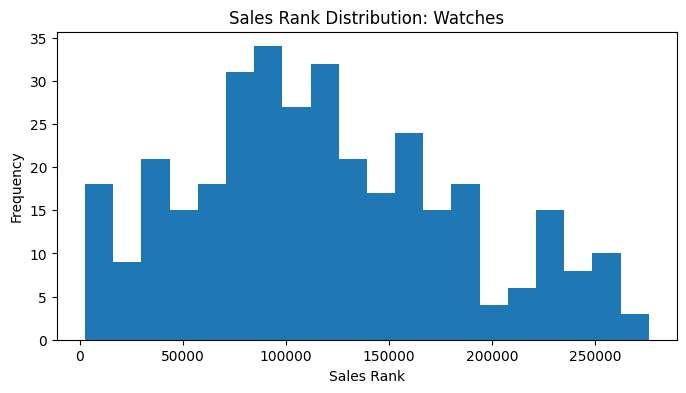

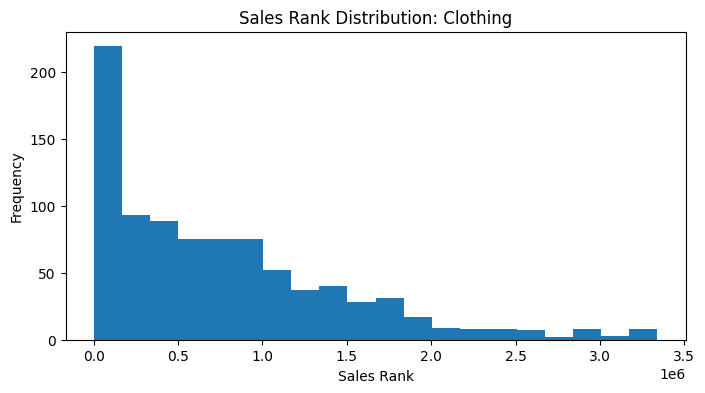

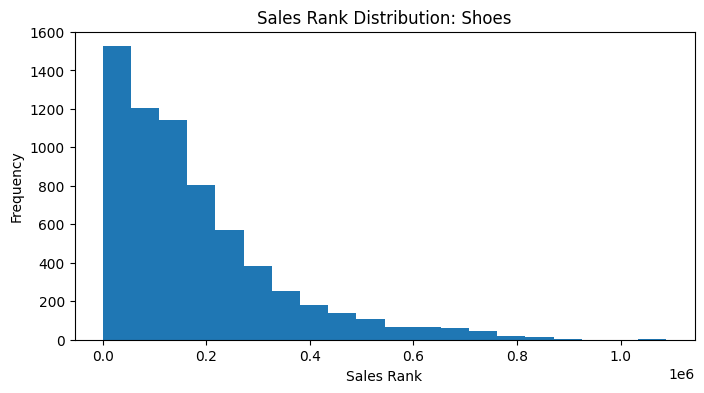

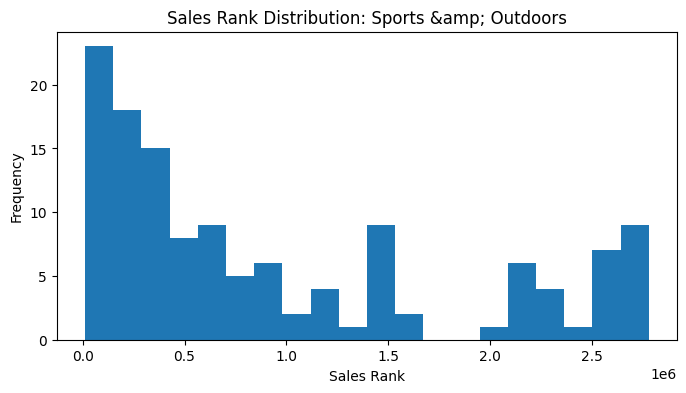

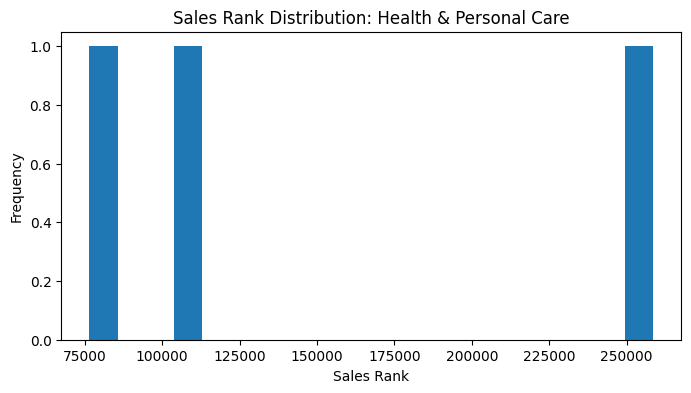

In [ ]:
df = df_sales.merge(df_ratings, on="asin", how="left")
import matplotlib.pyplot as plt

categories = df_sales['category'].unique()

for cat in categories:
    subset = df_sales[df_sales['category'] == cat]['rank']
    plt.figure(figsize=(8,4))
    plt.hist(subset, bins=20)
    plt.title(f"Sales Rank Distribution: {cat}")
    plt.xlabel("Sales Rank")
    plt.ylabel("Frequency")
    plt.show()


### Rating Distributions by Category


Across all categories, the rating distributions are strongly skewed toward high customer satisfaction, with 5-star ratings dominating every chart—most dramatically in Shoes and Clothing, where 5-star reviews vastly exceed all other rating levels combined. Lower ratings (1–2 stars) appear consistently but sparsely, suggesting that while negative sentiment exists, it represents a small minority of overall feedback. Watches and Sports & Outdoors show a somewhat more balanced spread across the 3–4-star range compared with the apparel categories, indicating more moderate or mixed product experiences. Overall, the patterns suggest that Amazon ratings for these categories exhibit a typical positivity bias, but also reflect real differences in perceived product quality—where Shoes and Clothing generate the strongest customer enthusiasm, while Watches and Sports & Outdoors show relatively more variability in satisfaction.


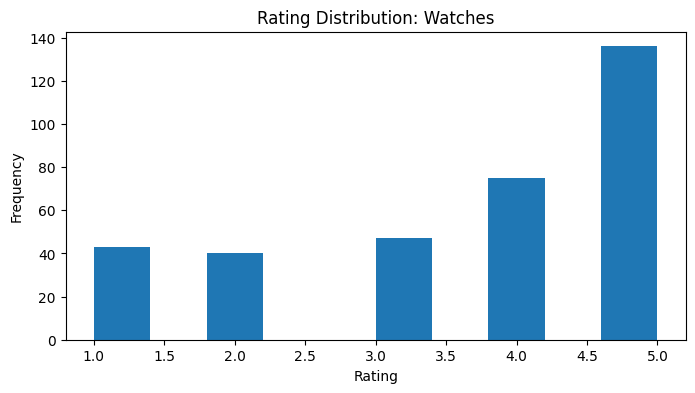

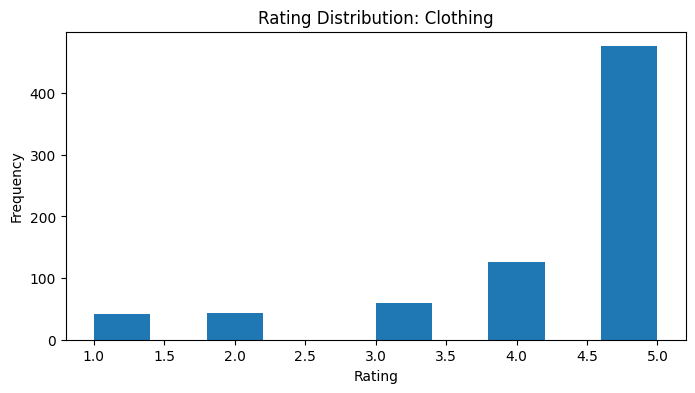

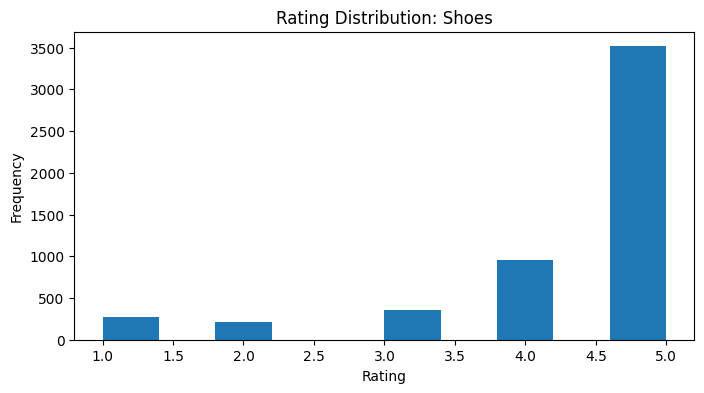

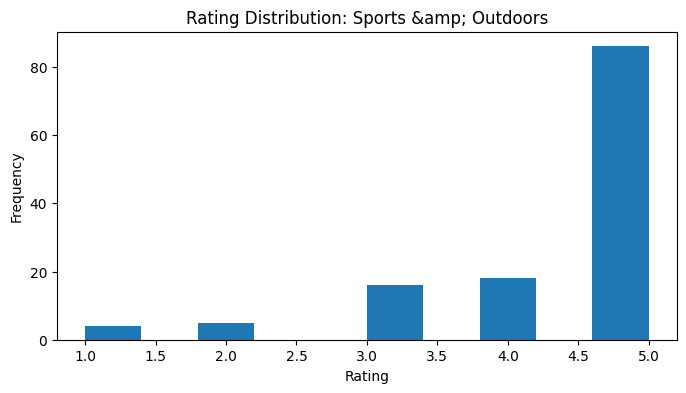

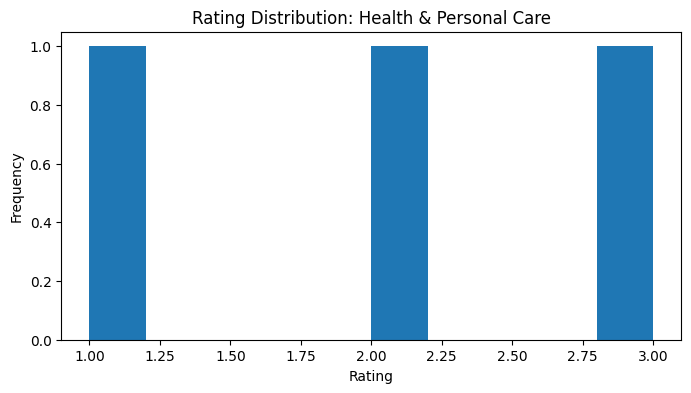

In [ ]:
categories = df['category'].unique()

for cat in categories:
    subset = df[df['category'] == cat]['rating'].dropna()
    plt.figure(figsize=(8,4))
    plt.hist(subset, bins=10)
    plt.title(f"Rating Distribution: {cat}")
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.show()


### Correlations between Rank and Rating

The correlation between sales rank and rating is effectively near zero across all major categories, indicating that higher customer ratings do not meaningfully predict better sales rank (or vice-versa). Clothing, Shoes, Watches, and Sports & Outdoors all show correlations clustered tightly around zero, suggesting that these categories experience high sales regardless of rating levels—likely due to brand strength, product visibility, pricing, and search-placement effects that outweigh rating sentiment. The one exception is Health & Personal Care, where the correlation appears high (≈0.78), but this is almost certainly an artifact of the very small sample size, not a real relationship. Overall, the results imply that in this dataset, ratings are not strong drivers of sales performance, and sales rank tends to be governed more by market dynamics than by incremental differences in customer star ratings.  


Interpreting these results for Nike:
Nike is likely less impacted by negative consumer ratings overall, a pattern shaped by high product volume and an already strong, positive brand perception that dominates customer sentiment. This is not to say that negative sentiment and its subsegments are unimportant—these insights remain invaluable for identifying areas of improvement and reinforcing what Nike already does well.


In [ ]:
df.groupby("category")[["rank", "rating"]].corr().unstack().iloc[:,1]


,rank
,rating
category,
Clothing,0.002674
Health & Personal Care,0.779295
Shoes,-0.011071
Sports &amp; Outdoors,-0.012551
Watches,0.004366


### Summary Statistics by Category for Rank and Ratings

We would note Nike's strengths appear in Shoes, Clothing, Sports and Outdoor product lines.  Watches notably show weaker average ratings.  We would avoid interpreting average sales rankings in absence to normalization which furthers the context of the sales ranking by category.  That is, we couldn't immediately gauge where an average rank of say 119,089 for watches stands in the field of all products and competitors for the watch categor, for example.  Normalizing allows us to better interpret this statistic in allowing us to understand percentage of rank compared to all competitor products in the watch category, for example.   

In [ ]:
df.groupby("category").agg(
    avg_rank=("rank","mean"),
    median_rank=("rank","median"),
    rank_std=("rank","std"),
    avg_rating=("rating","mean"),
    median_rating=("rating","median"),
    count=("asin","count")
)


,avg_rank,median_rank,rank_std,avg_rating,median_rating,count
category,,,,,,
Clothing,754240.059955,604982.5,709715.505625,4.276139,5.0,884
Health & Personal Care,147164.666667,106427.0,97576.686326,2.000000,2.0,3
Shoes,176714.677527,133580.0,162251.238417,4.357788,5.0,6599
Sports &amp; Outdoors,945689.392308,579386.0,901007.202501,4.372093,5.0,130
Watches,119089.921965,111879.0,65679.964586,3.648094,4.0,346


### Violin Plot of Sales Rank Distribution (Overall) by Rating

The violin plot shows that sales rank distributions remain broadly similar across all rating levels, even when viewed on a log scale. Although higher-rated products (4–5 stars) appear slightly more concentrated toward better ranks, the overall shape, spread, and density of each violin remain nearly identical. This indicates that products with low, moderate, or high ratings all occupy the same wide performance range—from top-selling items to those buried deep in the long tail. In practical terms, this reinforces the earlier correlation results: rating has little predictive power for sales rank, and marketplace performance is driven far more by factors like brand visibility, inventory volume, search placement, and category competitiveness than by marginal differences in star ratings.


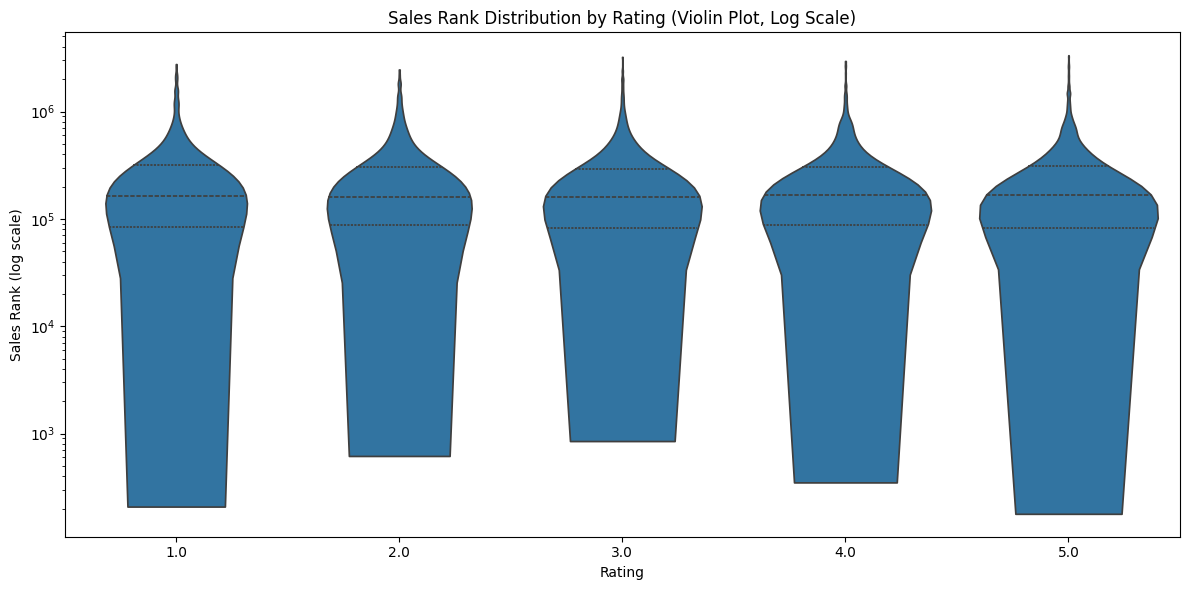

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))

sns.violinplot(
    x="rating",
    y="rank",
    data=df,
    cut=0,           # don't extend violins beyond data
    inner="quartile" # draws Q1/Q2/Q3 lines inside
)

plt.yscale("log")
plt.xlabel("Rating")
plt.ylabel("Sales Rank (log scale)")
plt.title("Sales Rank Distribution by Rating (Violin Plot, Log Scale)")
plt.tight_layout()
plt.show()


## Violin plots of Sales Rank by Rating, Split by Category

Violin plots are useful in given a descriptive visual reference of the distribution of Sales Ranking - in this case, and it is also worth highlighting that we are using log-scaling in noting that bulk disrbutions of sales rank also varies by several orders magnitdue in scaling from top to poorer sales performance.  We might be tempted to note the scale variability in sales ranking being particularly poor for certain products, but I would strongly caution that the sale ranking data comprises sales for many third party vendors via Amazon.  Thus, there can be largely scale and volumetric differences between vendors that adjust significantly comparative ranking from one to the next.  What does, however, remaing useful in such analysis is the notion of Consumer ratings and a product sales, and that we can further separate categoric relationships to see how overall specific categories are performing in terms of sales ranking and ratings.  

### Nike Shoes
Highest Rating and Sales Rank Distribution - We can see a bulk majority of the distribution peaks at ~ $ 10^5 $  with a long tail to truncated to a given top performer nearer to $ 100 $ Sale Ranking.  That is there are Nike shoe products that are likely closer to but greater than the top 100 of product sellers in such category.  We can also note that the truncated tail is of greater bulk compared to the worst performing which comprises fewer of such products.  These may simply be unique Nike products with differences in pricing variability.  Overall compared to other categories, we can note that Nike Shoes are particularly the strongest.   

As we descend in ratings, unsuprisingly, we would note the incling distributional shifts to poorer sales ranking, and this peak occurs at consumer rating 3.  However, as we continue moving towards the poorest consumer rating, we would note that there is a self-similar distribution to that of the highest consumer rating.  We might expect that Nike Shoe product lines that often had poorer ratings would also have pooerer sales, but we might also recall an early summary statstic which overall described Nike Shoe sales averaging a consumer rating of around 4.6.  Thus, a bulk majority of Nike Shoe Sales are well in the highly positive consumer rating region.  This suggest that likely have fewer poor consumer ratings - which also suggest that for those product rating reviews that are poor may not be necessarily characteristic of the shoe's overall lack of commercial appeal, but may relate more to other external problems - for example, order timeliness, packaging problems, etc.  These types of problems with the product are fundemenatally less likely to impact the overall sale of the product and are more quality assurance type problems that crop up in a way without significantly and adversely impacting overall sales of the product.  Hence, we still see a similar distributional sales ranking pattern to the highest customer ratings.

We might, otherwise, observe the natural tendency of product sales to poor sales ranking correlated to poorer reviews, however, occuring in the region of consumer ratings from 3 to 5 which suggests fundamentally that Nike's product sales and shoelines are managed strongly around product quality perception well.

### Nike Clothing

We note highly similar trends except weaker sales ranking patterns for Nike Clothing.  Higher-rated clothing items tend to achieve better ranks, but there is more variability than in shoes. Ratings matter, but other factors (style, brand, price) add noise.  Note:  we haven't performed a market comparative analysis to other maanufacturers to see how presumably Spots Clothing and Athletic Wear landscape would regard Nike Clothing here, but we can say safely that Nike is more dominant in the market of shoes.  


### Nike Sports and Outdoor

We could highlight and note that Sports category could refer to shoes that are specialized within market - e.g. football cleated shoe, or soccer cleated shoe.  We observe that relative the general Shoe category Sports and Outdoor categories show weaker sales ranking to Consumer ratings.  Noticeably, there is overall volatility between ratings and sales ranking distributions which suggests that sales overall within these product category types are also weaker.  We would also note the summary average rating of Nike Sport and Outdoor products is slightly higher than Nike Shoes which suggests that we might expect in a less sales dominant category greater volatility in sales ranking to shoe ratings as ratings decline which easily appears visually confirmed.  More dominant sales of a product line at rating 3 may also suggest that consumers may be willing to overlook some issues with a given product if there are less alternative options for highly specialized niche shoe productlines, but again to caution there are also likely fewer reviews in thie product rating area.   

### Nike Watches
It is worth noting in this segment we have overall comparatively higher performing sales ranking, but smaller scale distribution representation.  There appears to be little stronger correspondence to customer ratings and sales ranking which may suggest that despite Nike's well known product watch products are more observed by product reviews prior to consumer purchase (?).  This may suggest that Nike remains in this product category lesser known, so consumer's are more likely to pay attention to consumer product reviews.  

### Health and Personal Care

There is notably higher volatility and likely lower sales volume in this product category, suggesting that consumers are less familiar with Nike in the Health and Personal Care space. We also see that Nike has only modest sales-rank penetration here, indicating relatively limited reach and weaker market presence compared with its core product categories.


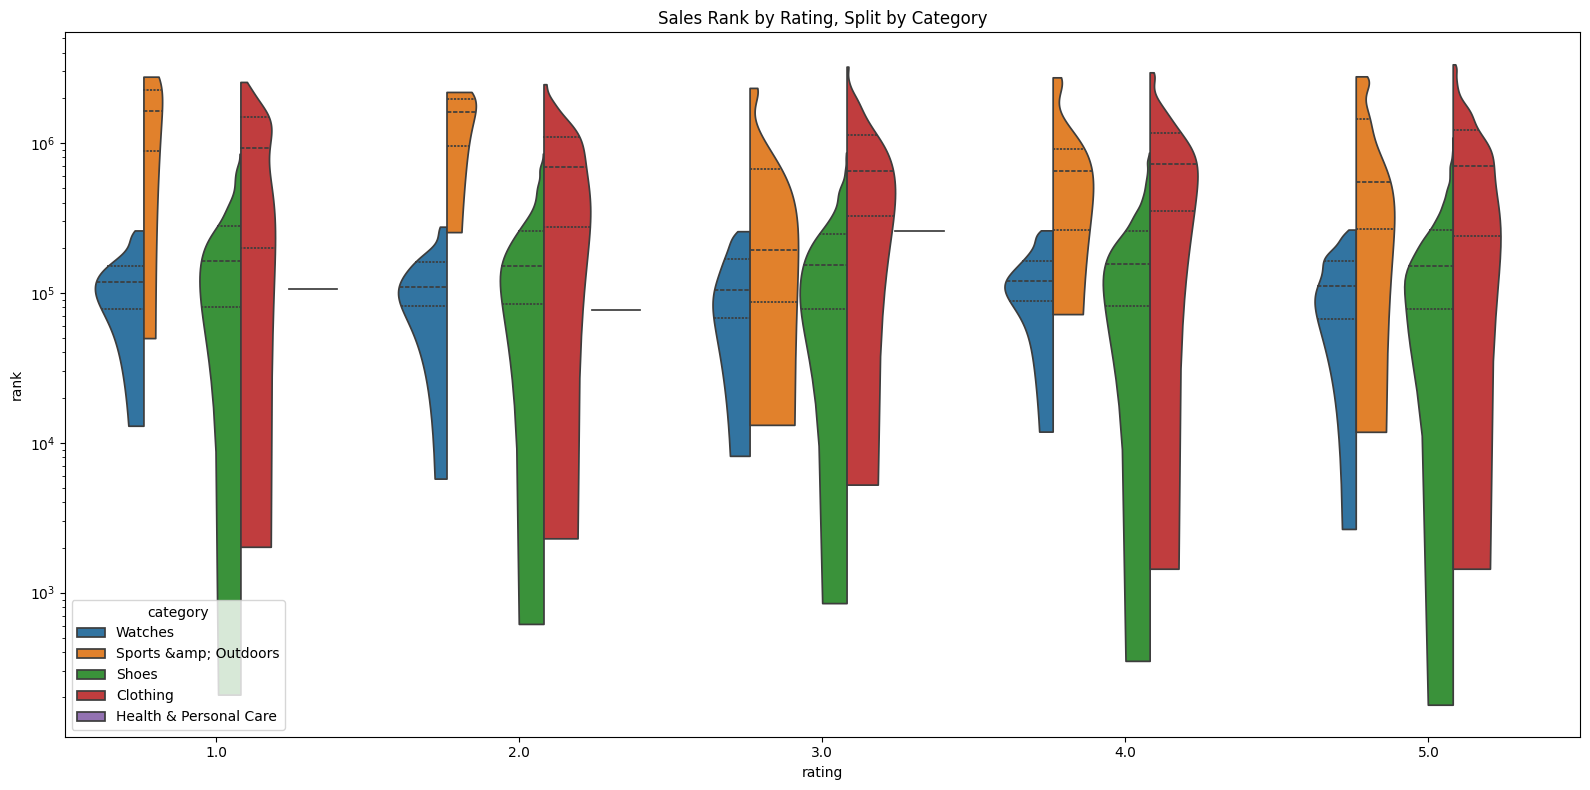

In [ ]:
plt.figure(figsize=(16,8))
sns.violinplot(
    x="rating",
    y="rank",
    hue="category",
    data=df,
    split=True,
    inner="quartile",
    cut=0
)
plt.yscale("log")
plt.title("Sales Rank by Rating, Split by Category")
plt.tight_layout()
plt.show()


### Ridgeline Plot Sales Rank Distribution by Category


The ridgeline plot highlights strong category-level differences in sales rank performance when viewed on a log scale. Shoes and Watches cluster tightly around lower log10 ranks, indicating consistently better sales and less variance within these categories. Health & Personal Care, despite its small sample, also centers in this high-performing range. In contrast, Clothing and Sports & Outdoors shift noticeably to the right, reflecting generally weaker sales and much broader variability, with long tails extending into the poorest-performing ranks. These patterns show that footwear and watches tend to exhibit more stable, concentrated sales strength, while clothing and sports/outdoors products occupy more diffuse, saturated markets where performance varies widely.


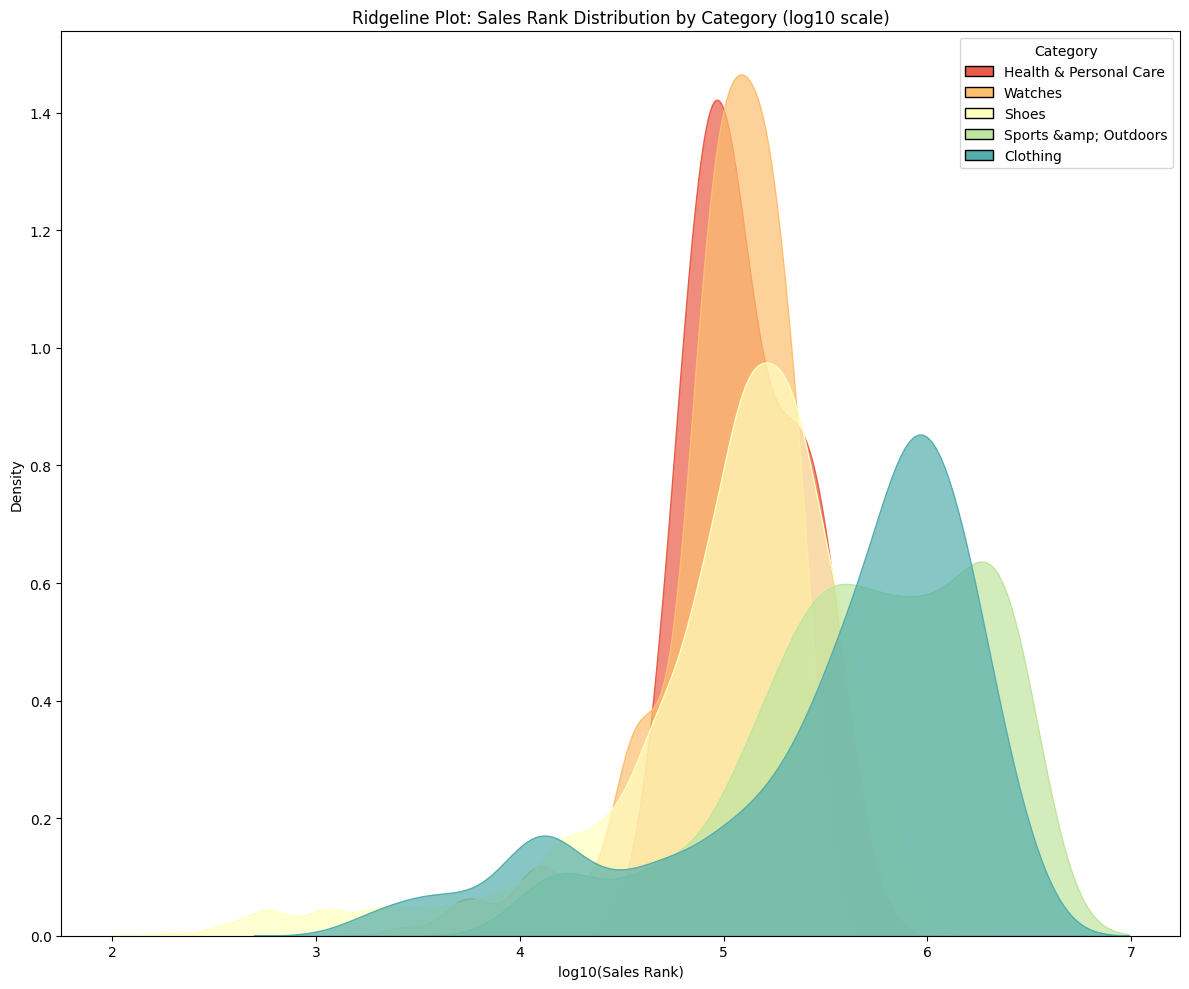

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

categories = (
    df.groupby("category")["rank"]
      .median()
      .sort_values()
      .index
)

palette = sns.color_palette("Spectral", len(categories))

plt.figure(figsize=(12, 10))

for i, (cat, color) in enumerate(zip(categories, palette)):
    subset = np.log10(df[df["category"] == cat]["rank"])

    sns.kdeplot(
        subset,
        fill=True,
        alpha=0.7,
        linewidth=1,
        color=color,
        clip=(0, None),
        bw_adjust=0.8
    )

# --- Legend Handles ---
handles = [Patch(facecolor=color, edgecolor='black') for color in palette]
labels = list(categories)

plt.legend(handles, labels, title="Category", loc="upper right")

plt.title("Ridgeline Plot: Sales Rank Distribution by Category (log10 scale)")
plt.xlabel("log10(Sales Rank)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


## Topic Modeling

### Description of Modeling Imports


This imports the essential libraries for text preprocessing and topic modeling and prepares spaCy’s English language model for efficient linguistic processing. It brings in regular expressions and string utilities for cleaning text, and loads gensim components including `Dictionary`, `LdaModel`, and `simple_preprocess` for building vocabularies, creating bag-of-words representations, and training LDA topic models. The `spacy.load()` call loads the lightweight en_core_web_sm English model while disabling the parser and named-entity recognizer to speed up preprocessing. This setup provides the core infrastructure needed to clean text, tokenize it, lemmatize it, build corpora, and train topic models.


In [ ]:
import re
import string
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim import corpora
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


### Preprocessing for LDA Topic Modeling


The `preprocess_texts_spacy` function performs full text preprocessing using spaCy to produce clean, lemmatized token lists suitable for topic modeling. It processes documents in batches for efficiency and applies standard cleaning steps: converting tokens to lowercase, removing punctuation, numbers, whitespace, and tokens shorter than two characters. Each token is replaced with its lemma, ensuring that different word forms (e.g., *running*, *ran*, *runs*) are normalized to a common base. The result is a list of tokenized, lemmatized documents prepared for downstream modeling.

The `build_gensim_corpus` function then uses these cleaned token lists to construct the data structures needed by gensim’s LDA topic model. It first builds a `Dictionary` object that maps each unique token to an integer ID, and optionally filters extremely rare or overly frequent terms to reduce noise. It then transforms each document into a bag-of-words (BoW) representation, where each document is expressed as a list of `(token_id, count)` pairs. The function returns the tokenized documents, the dictionary, and the full BoW corpus, providing a complete gensim-compatible pipeline for training LDA models.

---





In [ ]:
from string import punctuation

In [ ]:
import sys
# Get a dictionary of all loaded modules
print(sys.modules)
# Get just the keys (module names)
print(sys.modules.keys())

{'sys': <module 'sys' (built-in)>, 'builtins': <module 'builtins' (built-in)>, '_frozen_importlib': <module '_frozen_importlib' (frozen)>, '_imp': <module '_imp' (built-in)>, '_thread': <module '_thread' (built-in)>, '_warnings': <module '_warnings' (built-in)>, '_weakref': <module '_weakref' (built-in)>, '_io': <module '_io' (built-in)>, 'marshal': <module 'marshal' (built-in)>, 'posix': <module 'posix' (built-in)>, '_frozen_importlib_external': <module '_frozen_importlib_external' (frozen)>, 'time': <module 'time' (built-in)>, 'zipimport': <module 'zipimport' (frozen)>, '_codecs': <module '_codecs' (built-in)>, 'codecs': <module 'codecs' (frozen)>, 'encodings.aliases': <module 'encodings.aliases' from '/usr/lib/python3.12/encodings/aliases.py'>, 'encodings': <module 'encodings' from '/usr/lib/python3.12/encodings/__init__.py'>, 'encodings.utf_8': <module 'encodings.utf_8' from '/usr/lib/python3.12/encodings/utf_8.py'>, '_signal': <module '_signal' (built-in)>, '_abc': <module '_abc' 

In [ ]:
def preprocess_texts_spacy(texts, lang="en"):
    """
    Approximate your original build_corpus behavior, but return
    token lists for gensim:

    - Lemmatize
    - lowercase
    - remove punctuation
    - remove numbers
    - remove tokens shorter than 2 chars
    """
    docs_tokens = []

    for doc in nlp.pipe(texts, batch_size=1000):
        tokens = []
        for token in doc:
            # skip spaces, punctuation, numbers
            if token.is_space:
                continue
            if token.is_punct:
                continue
            if token.like_num:
                continue

            lemma = token.lemma_.lower().strip()

            # remove punctuation chars, very short tokens
            if len(lemma) < 2:
                continue
            if all(ch in punctuation for ch in lemma):
                continue

            tokens.append(lemma)

        docs_tokens.append(tokens)

    return docs_tokens


def build_gensim_corpus(texts, lang="en"):
    """
    Gensim-equivalent of your build_corpus:
    returns (tokenized_docs, dictionary, bow_corpus)
    """
    tokenized_docs = preprocess_texts_spacy(texts, lang=lang)

    # Create dictionary (term → id mapping)
    dictionary = corpora.Dictionary(tokenized_docs)

    # Optional: filter extremes roughly similar to tmtoolkit cleaning
    # tweak thresholds as you like
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Bag-of-words corpus
    bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    return tokenized_docs, dictionary, bow_corpus



This builds and trains an LDA topic model on the matched Amazon reviews. First, it extracts the actual review text from `matched_reviews` and passes the list of strings into `build_gensim_corpus`, which returns the preprocessed tokens, a gensim dictionary, and the bag-of-words corpus. Next, the `lda_params` dictionary specifies the modeling hyperparameters: a 50-topic model (`n_topics`), relatively low topic–word prior (`eta = 0.01`), symmetric document–topic prior (`alpha = 1/50`), 500 Gibbs-style iterations, and a fixed random seed for reproducibility. These settings are then mapped into gensim’s `LdaModel`, which is initialized with the BoW corpus and dictionary, the desired number of topics, priors (`alpha`, `eta`), number of iterations and passes through the corpus, and evaluation frequency. The resulting `lda_model` object is a fitted topic model that can be used to inspect topics, infer topic distributions for documents, and generate downstream visualizations.


In [ ]:
review_texts = [r.get("reviewText", "") for r in matched_reviews.values()]

tokens, dictionary, bow_corpus = build_gensim_corpus(review_texts)

lda_params = {
    'n_topics': 50,
    'eta': 0.01,
    'n_iter': 500,        # we'll map this to 'iterations'
    'random_state': 1234,
    'alpha': 1/50
}

lda_model = LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=lda_params['n_topics'],
    alpha=lda_params['alpha'],
    eta=lda_params['eta'],
    random_state=lda_params['random_state'],
    iterations=lda_params['n_iter'],
    passes=10,           # you can tune this; 5–20 is common
    eval_every=1         # set 0 to turn off per-pass eval
)


In [ ]:
for i, topic in lda_model.print_topics(num_topics=10, num_words=10):
    print(f"Topic {i}: {topic}")


Topic 5: 0.089*"like" + 0.049*"really" + 0.039*"look" + 0.035*"material" + 0.034*"tennis" + 0.032*"good" + 0.031*"that" + 0.029*"it" + 0.026*"leather" + 0.023*"soft"
Topic 35: 0.052*"stylish" + 0.050*"too" + 0.039*"jordan" + 0.037*"ok" + 0.036*"tight" + 0.032*"definitely" + 0.027*"width" + 0.026*"narrow" + 0.024*"with" + 0.024*"classic"
Topic 15: 0.077*"of" + 0.066*"off" + 0.043*"take" + 0.040*"fall" + 0.034*"kind" + 0.028*"on" + 0.026*"come" + 0.025*"out" + 0.025*"almost" + 0.021*"apart"
Topic 20: 0.056*"not" + 0.048*"do" + 0.043*"to" + 0.032*"for" + 0.028*"have" + 0.023*"an" + 0.021*"even" + 0.020*"know" + 0.018*"customer" + 0.017*"service"
Topic 2: 0.071*"of" + 0.066*"sneaker" + 0.058*"wear" + 0.053*"my" + 0.047*"these" + 0.032*"compliment" + 0.029*"get" + 0.029*"lot" + 0.028*"have" + 0.027*"on"
Topic 34: 0.153*"she" + 0.101*"my" + 0.077*"daughter" + 0.077*"we" + 0.067*"for" + 0.041*"love" + 0.038*"her" + 0.027*"to" + 0.023*"friend" + 0.019*"this"
Topic 16: 0.219*"it" + 0.085*"love"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("drive/MyDrive/MSDS_gensim_bundle.pkl", "wb") as f:
    pickle.dump({
        "model": lda_model,
        "dictionary": dictionary,
        "corpus": bow_corpus
    }, f)
f.close()

In [ ]:
import warnings

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message="datetime.datetime.utcnow"
)
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="jupyter_client.session"
)



In [ ]:
!pip install pyLDAvis



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 44.4 MB/s eta 0:00:00


In [ ]:
'''
try:
  import pyLDAvis
except:
  !pip install pyLDAvis
  import pyLDAvis
'''

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import pickle

with open("drive/MyDrive/MSDS_gensim_bundle.pkl", "rb") as f:
    bundle = pickle.load(f)
lda_model = bundle["model"]
dictionary = bundle["dictionary"]
bow_corpus = bundle["corpus"]
f.close()

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # note: gensim_models, not gensim
from IPython.display import HTML, display

## LDA Intertopic Distance & Cluster Structure

Using the intertopic coordinates embedded in the pyLDAVis HTML (the `mdsDat` section), the 50 topics form several tight islands on the 2D map. Conceptually, they group into about six clusters of themes:

1. Cluster 0 – Performance running shoes & general athletic purchase experience

   * Topics: 1, 2, 3, 5, 7, 8, 9, 11, 14, 30
   * Dominated by words about running shoes (Asics, gel, pronation, minimalist, barefoot, hyperdunk) and more general review language about shirts, satisfaction, shopping, and spending.
   * These topics sit close together, indicating reviews that talk about technical shoe performance + overall satisfaction with athletic gear purchases.

2. Cluster 1 – Men’s lifestyle/performance footwear & price/value perceptions

   * Topics: 37, 39, 40, 44, 45
   * Mix of words like *cortez, elite, force, combat, classic, beach, pricey, lifestyle, pant, sporting*.
   * These topics cluster around men’s lifestyle / performance shoes and apparel, often with emphasis on value, condition, and expectations.

3. Cluster 2 – Family recipients, comfort, gifting & cleated footwear

   * Topics: 6, 10, 15, 16, 17, 19, 31, 34, 41, 42
   * Strong presence of relationship words (*grandson, boyfriend, parent, daughter, wife, girl, nephew, toddler*) plus comfort, authenticity, hoodie, cleat, soccer, football*.
   * Cluster captures gifting and family-oriented reviews, comfort/fit, authenticity, and kids’/cleated sports footwear.

4. Cluster 3 – Spanish-language & basketball/streetwear themes

   * Topics: 46, 47, 48, 49, 50
   * Contains many Spanish tokens (*que, para, producto, en, bastante, comodo, venezuela*) and brand cues (*adidas, lebron, amazing, collector*).
   * Represents a Spanish-speaking review segment, often on basketball/streetwear shoes and related products.

5. Cluster 4 – Color/style, casual apparel & outerwear

   * Topics: 12, 13, 18, 20, 21, 22, 24, 26, 32, 38
   * Heavy on visual/style words (*penny, stain, compliment, colorful, pink, red, neon, boot, warm, turquoise, khaki, vacation, occasion, skate, canvas*).
   * This island is largely about clothing, colors, fashion appeal, and outerwear (boots, jackets, etc.).

6. Cluster 5 – Accessories & quality/retailer issues

   * Topics: 4, 23, 25, 27, 28, 29, 33, 35, 36, 43
   * Keywords include *watch, display, band, battery, wallet, backpack, sunglass, fake, frame, equipment, footlocker, refund, fall apart, glue, sweaty, zumba*.
   * This cluster captures accessories (watches, bags, sunglasses) and product quality or retailer/return issues.

High-level intertopic takeaway:
The map is organized roughly along product type (footwear vs apparel vs accessories) and review focus (performance/fit vs style/appearance vs authenticity/quality vs retailer experience), with a clearly separated Spanish-language subspace.

##  LDA Topic-by-Topic Descriptions




 Topic 1 (Cluster 0) – Asics performance running shoe fit & construction

* Top terms: asics, marathon, lacing, lover, overly, concerned, conform, stitching, health, rarely
* Likely category: Reviews focused on Asics running shoes, especially for marathon use, talking about lacing, fit/conformity, stitching quality, and overall comfort/“health” of the foot.



 Topic 2 (Cluster 0) – Pronation & technical running shoe behavior

* Top terms: promise, settle, initial, pronate, timely, crease, reach, vomero, repair, square
* Likely category: Technical discussion of pronation control shoes (e.g., Nike Vomero), how they settle in over time, creasing behavior, and whether they deliver on performance “promises”.


 Topic 3 (Cluster 0) – Cushioning systems & minimalist stability

* Top terms: gel, remind, mid, minimal, prime, dont, stability, rocky, flywire, catch
* Likely category: Reviews highlighting gel cushioning, “minimal” designs, stability on rocky terrain, and Nike Flywire. This is about ride quality & support.



 Topic 4 (Cluster 5) – Sports watches & functionality

* Top terms: watch, display, band, battery, swim, butt, backlight, stopwatch, wrist, basket
* Likely category: Watches for sports or daily use: display visibility, band comfort, battery performance, swim suitability, backlight/stopwatch, and overall wrist feel.



 Topic 5 (Cluster 0) – General concern, pain, and daily-use conditions

* Top terms: afraid, town, office, hear, breaking, stuck, evening, hurt, med, boat
* Likely category: Mixed reviews where people mention being afraid something will break, feeling hurt, wearing items around town/office/evening, and possibly dealing with pain/medical issues in everyday use.


 Topic 6 (Cluster 2) – Gifts for grandsons, boyfriends & men’s outfits

* Top terms: grandson, he, thrill, boyfriend, outfit, bounce, his, tho, sweater, son
* Likely category: Reviews about buying apparel/footwear as gifts (for grandsons, boyfriends, sons), focusing on whether the recipient was thrilled and how the outfit looked/felt.



 Topic 7 (Cluster 0) – Shirts, satisfaction & mixed English/Spanish

* Top terms: shirt, satisfaction, llego, dunk, picky, lifting, spray, cotton, unos, google
* Likely category: T-shirts or training shirts, satisfaction levels, possibly basketball (dunk), cotton quality, a bit of Spanish (“llego”, “unos”), and people who are picky about shirts.



 Topic 8 (Cluster 0) – Warmth, comfort preferences & “traditional” styling

* Top terms: forever, resist, common, sometime, preference, youtube, opportunity, warmth, traditional, airy
* Likely category: Reviews on comfort/warmth vs airy feel, personal preferences, and perhaps items discovered via YouTube or online shopping, with a tilt toward traditional styling.



 Topic 9 (Cluster 0) – Average general-use experiences & casual wear

* Top terms: average, loosen, fly, lesson, sister, core, surely, possibly, party, mom
* Likely category: General, more neutral reviews (average, loosen), often involving family members (sister, mom) and party/casual use.



 Topic 10 (Cluster 2) – Synthetic materials & discomfort trade-offs

* Top terms: discomfort, exceed, synthetic, future, artificial, eye, i., muddy, another, cute
* Likely category: Trade-offs between synthetic / artificial materials, discomfort, and the item being visually cute. Possibly about fashion shoes or clothing that look good but feel off.



 Topic 11 (Cluster 0) – Barefoot/minimalist & hyperdunk-style performance

* Top terms: bone, level, barefoot, thought, hyperdunk, retire, cushioned, minimalist, pavement, shift
* Likely category: Barefoot or minimalist shoes vs cushioned options (like Hyperdunk), with emphasis on pavement performance and how it feels “to the bone”.



 Topic 12 (Cluster 4) – Women’s pants/khakis & compliments

* Top terms: penny, womens, stain, compliment, ruin, advantage, colorful, wore, khaki, tenis
* Likely category: Women’s clothing (pants/khakis, possibly sneakers), with focus on stains, compliments, colorful looks, and whether wear/tear “ruins” the appearance.



 Topic 13 (Cluster 4) – Everyday casual items & small annoyances

* Top terms: simple, gum, ebay, hip, wipe, snag, definitly, absolute, cell, food
* Likely category: Simple casual purchases, often via eBay, with small annoyances (snags, gum, needing to wipe things off), and general lifestyle context (cell, food).



 Topic 14 (Cluster 0) – Nike.com shopping, uniforms & lounge wear

* Top terms: demand, uniform, shopping, stretchy, nike.com, vibrant, imagine, lounge, bear, worry
* Likely category: Buying uniforms or stretchy lounge clothing via nike.com, focusing on vibrant colors, fit, and whether it meets demand/expectations.



 Topic 15 (Cluster 2) – Packaging, authenticity & affordable “blazer/roshe”

* Top terms: promptly, brown, packaging, authentic, affordable, request, rich, blazer, product, roshe
* Likely category: Reviews on shoe packaging, authenticity vs fake, and affordability, especially around models like Blazer or Roshe.



 Topic 16 (Cluster 2) – Genuine products & repeat purchases

* Top terms: anyone, genuine, country, fair, re, throughout, reorder, higher, camp, gorgeous
* Likely category: Discussions about whether items are genuine vs fake, feeling that pricing is fair, and reordering or buying again. Often about attractive/gorgeous items.



 Topic 17 (Cluster 2) – Parents’ opinions & suitability

* Top terms: parent, usual, attractive, opinion, league, very, suitable, happy, washing, slightly
* Likely category: Parents reviewing items (likely for kids in sports leagues), commenting on attractiveness, washing, suitability and happiness with the purchase.



 Topic 18 (Cluster 4) – Vacation/retailer and photo-based expectations

* Top terms: photo, typically, beat, vacation, okay, forward, reality, retailer, cheaply, colour
* Likely category: Items bought for vacation where online photos vs reality differ, concerns about cheap feel, and dealing with the retailer if expectations aren’t met.



 Topic 19 (Cluster 2) – Slippers & casual comfort for men and women

* Top terms: woman, sad, slipper, intend, lift, cash, man, perfectly, essentially, perfect
* Likely category: Slippers or casual comfort shoes, for both men and women, that may or may not live up to “perfectly perfect” comfort.



 Topic 20 (Cluster 4) – Roomy gear & zipper/fit details

* Top terms: ride, tank, term, spacious, roomy, oppose, yourself, fabulous, zipper, wait
* Likely category: Clothing or bags that are spacious/roomy, with attention to zippers, fit and overall feel (fabulous vs not).



 Topic 21 (Cluster 4) – Shoes for occasions & teens, bulkiness & wet conditions

* Top terms: must, occasion, somewhat, shoes, slack, teenage, wet, personal, bulky, recomend
* Likely category: Shoes for specific occasions or teenagers, evaluating bulkiness and performance in wet conditions.



 Topic 22 (Cluster 4) – Skate shoes, canvas, and leather build

* Top terms: skate, carbon, canvas, pad, dollar, prompt, slow, superb, leather, shape
* Likely category: Skate shoes or skate-related footwear, with canvas/leather construction and comments on value (dollar) and durability.



 Topic 23 (Cluster 5) – Wallets, backpacks & compartments

* Top terms: wonder, wallet, backpack, section, bouncy, fusion, inner, control, beware, dual
* Likely category: Bags & wallets focusing on sections/compartments, inner layout, and warnings about design quirks.



 Topic 24 (Cluster 4) – Hiking & physical activity apparel

* Top terms: temple, fresh, sweet, everybody, physical, self, hiking, plain, them, theses
* Likely category: Hiking or active outdoor apparel, with emphasis on feeling fresh/sweet and suitable for physical activity.



 Topic 25 (Cluster 5) – Fake sunglasses & vendor issues

* Top terms: fake, frame, sunglass, youth, vendor, lens, process, bridge, dad, damn
* Likely category: Sunglasses (often fake/counterfeit), with problems in frames, lenses, and frustration with the vendor or buying process.



 Topic 26 (Cluster 4) – Colorways & Lunarglide styling

* Top terms: pink, red, lunarglide, silver, black, neon, combination, lite, texture, hopefully
* Likely category: Color combinations and design for shoes (e.g., Lunarglide), focusing on neon, pink/red/black/silver and overall texture.


 Topic 27 (Cluster 5) – Bags, timers & interval training gear

* Top terms: agree, bag, timer, form, individual, motion, deep, plenty, interval, edge
* Likely category: Gear used for interval training or workouts (bags, timers), emphasizing form, motion, and having plenty of room.



 Topic 28 (Cluster 5) – Equipment, retailers (Footlocker) & restocking

* Top terms: intense, equipment, restock, footlocker, hit, list, subtle, elsewhere, retail, whether
* Likely category: Sports equipment and retailer experiences (notably Footlocker), concerns about restocking and availability.



 Topic 29 (Cluster 5) – Limited editions & longevity

* Top terms: luck, handsome, lasting, edition, waste, fix, extended, separate, limited, serve
* Likely category: Limited edition or special-release items, where reviewers talk about luck, handsome looks, longevity, and whether they’re worth the price.



 Topic 30 (Cluster 0) – Spending, shipping & guarantee

* Top terms: game, cover, spend, system, warning, shipper, increase, waist, invest, guarantee
* Likely category: Reviews that mix spending/investment, shipping experiences, and sometimes gear used for “game” (sporting context) along with fit (waist).


 Topic 31 (Cluster 2) – Kids’ cleats & growing room

* Top terms: nephew, cleat, season, soccer, child, flip, grow, football, cushy, shipment
* Likely category: Youth soccer/football cleats for nephews/children, considering fit over a season, room to grow, and shipment.



 Topic 32 (Cluster 4) – Adorable toddler items & sizing

* Top terms: slim, adorable, doctor, machine, toddler, grandaughter, rise, goal, sadly, selection
* Likely category: Toddler or small children’s apparel/footwear, often for granddaughters, focusing on being adorable but sometimes with sizing or selection issues.


 Topic 33 (Cluster 5) – Refunds & poor product experience

* Top terms: grand, and/or, refund, accurate, simply, horrible, flap, kangaroo, interested, appealing
* Likely category: Complaint-heavy reviews where people seek refunds due to horrible products, inaccurate descriptions, or poor design (flaps, etc.).



 Topic 34 (Cluster 2) – Daughters & team apparel

* Top terms: flash, daughter, team, upon, she, bonito, manage, girlfriend, responsable, obvious
* Likely category: Apparel or shoes for daughters/girlfriends, often in a team sports context, with some Spanish (“bonito”, “responsable”).



 Topic 35 (Cluster 5) – Pro-quality gear & braces

* Top terms: original, pro, fitting, truly, reasonably, natural, pop, reputation, elliptical, brace
* Likely category: Pro-style or “original” gear, possibly braces or supportive equipment, focusing on fit, reputation, and performance.


 Topic 36 (Cluster 5) – Shoes falling apart & build quality

* Top terms: various, fall, apart, glue, ultra, damage, ton, major, kind, shoezoo
* Likely category: Strong emphasis on build quality problems—shoes falling apart, glue issues, damage, and complaints about specific sellers or brands.



 Topic 37 (Cluster 1) – Cortez & men’s shoe availability

* Top terms: soul, land, info, relax, title, cortez, hell, mens, available, correct
* Likely category: Reviews around Nike Cortez or other men’s shoes, focusing on availability, correctness of what was received, and overall comfort.



 Topic 38 (Cluster 4) – Boots & cold weather outerwear

* Top terms: boot, warm, clean, shoulder, amazingly, weather, turquoise, gain, speedy, wonderfully
* Likely category: Boots and outerwear, praising warmth and performance in weather, plus a bit of style (turquoise coloring).



 Topic 39 (Cluster 1) – “Elite/Force” models & dissatisfaction

* Top terms: elite, force, flexibility, pick, scamme, unhappy, glow, disney, combat, description
* Likely category: Possibly Nike Elite/Force models or similar, featuring flexibility vs stiffness, and complaints about being scammed or unhappy with the description vs reality.



 Topic 40 (Cluster 1) – Condition and seller responsiveness

* Top terms: exactly, incredibly, condition, complement, package, recieve, bring, respond, fire, worn
* Likely category: Focus on item condition (new vs worn), packaging, and whether the seller responds appropriately when issues arise.



 Topic 41 (Cluster 2) – Hoodies & fashion appeal

* Top terms: max, fashionable, justice, web, grade, favor, manufacture, hoodie, misleading, peel
* Likely category: Hoodies and fashion apparel, with concerns about misleading images, peeling logos/graphics, and overall fashionability.



 Topic 42 (Cluster 2) – Women’s shoes & confidence

* Top terms: girl, feather, wife, sneak, select, wish, pleasant, confidence, shox, complaint
* Likely category: Women’s performance/lifestyle shoes (including models like Shox), emphasizing confidence, comfort, and occasional complaint.



 Topic 43 (Cluster 5) – Workout classes (Zumba etc.) & sweat

* Top terms: steal, awful, sweaty, class, purple, zumba, impression, practical, teen, ground
* Likely category: Shoes or clothing for workout classes (Zumba, etc.), where people talk about sweat, grip on the ground, practicality, and style (purple).


 Topic 44 (Cluster 1) – Classic beach/army style & price

* Top terms: bc, beach, reasonable, grown, classic, pricey, ok, ii, underneath, army
* Likely category: Classic-looking shoes or apparel (possibly army-style or beach shoes), with commentary on price vs reasonable value.


 Topic 45 (Cluster 1) – Vapor & lifestyle/sport pants

* Top terms: tighten, vapor, yesterday, lifestyle, pant, sporting, fat, lil, tag, severe
* Likely category: Vapor-branded gear or sport pants, dealing with tightening, fit issues, tags, and how they perform in a lifestyle vs sporting context.



 Topic 46 (Cluster 3) – Spanish-language product quality (outsole, producto)

* Top terms: que, outsole, para, un, el, se, muy, la, de, producto
* Likely category: Spanish-language reviews focusing on outsole and general product quality, typical of Spanish-speaking customers discussing shoe performance.



 Topic 47 (Cluster 3) – Adidas & variety in Spanish/English mix

* Top terms: practically, variety, adidas, final, sleep, directly, page, incredible, reliable, wiggle
* Likely category: Reviews of Adidas products, variety and reliability, often in a Spanish/English blend.



 Topic 48 (Cluster 3) – LeBron, collectors & excitement

* Top terms: amazing, typical, wow, collector, ve, alright, thursday, lebron, sturdy, estimate
* Likely category: Collector-type basketball shoes (e.g., LeBron), with excitement (wow, amazing), sturdiness, and a collector mentality.



 Topic 49 (Cluster 3) – Aesthetic judgments & Spanish flavor

* Top terms: advertise, describe, :d, middle, ugly, encanto, pleasure, tired, convenient, till
* Likely category: Mixed English/Spanish reviews focusing on aesthetic judgments (ugly vs encanto = charm), convenience, and whether advertising matches reality.


 Topic 50 (Cluster 3) – Spanish: comfort, expectations & occasions

* Top terms: wash, en, expectation, neat, birthday, bastante, venezuela, comodo, club, sight
* Likely category: Spanish-language reviews related to comfort (“comodo”), expectations, special occasions (birthday, club) and some geographic context (Venezuela).




In [ ]:
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary)
#pyLDAvis.display(vis)  # in notebook
# Actually display it
#display(vis)      # or just `vis` as the last line in the cell
# Optionally save to HTML
html = pyLDAvis.prepared_data_to_html(vis)
display(HTML(html))

pyLDAvis.save_html(vis, "drive/MyDrive/MSDS_gensim_lda_vis.html")


In [ ]:
import json
import os
import pandas as pd
try:
  from bertopic import BERTopic
except:
  !pip install bertopic[all]
  os.kill(os.getpid(), 9)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
file_path = "drive/MyDrive/matched_reviews.pkl"
texts = []
with open("drive/MyDrive/MSDS_Matched_Reviews.jsonl") as reviews_file:
    for review in reviews_file:
        data = json.loads(review)
        texts.append(data["reviewText"])
reviews_file.close()

In [ ]:
texts[0]

'Very cute and is really practical. Fits better on smaller wrists which is my case. I wear them everywhere. I really love this watch!'

In [ ]:
len(texts)

6863

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(texts)

2025-11-09 19:05:06,613 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/215 [00:00<?, ?it/s]

2025-11-09 19:08:43,169 - BERTopic - Embedding - Completed ✓
2025-11-09 19:08:43,171 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-09 19:09:27,279 - BERTopic - Dimensionality - Completed ✓
2025-11-09 19:09:27,280 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-09 19:09:29,762 - BERTopic - Cluster - Completed ✓
2025-11-09 19:09:29,771 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-09 19:09:30,344 - BERTopic - Representation - Completed ✓


In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2320,-1_the_and_shoes_to,"[the, and, shoes, to, shoe, they, them, my, th...","[The design, weight, feel is great!You don't e..."
1,0,343,0_watch_it_this_band,"[watch, it, this, band, is, the, wrist, batter...",[I like this watch...the only thing is that I ...
2,1,261,1_running_run_shoes_these,"[running, run, shoes, these, for, shoe, you, a...",[I have put many miles into these shoes as a r...
3,2,179,2_he_son_loves_old,"[he, son, loves, old, shoes, year, my, them, h...",[Bought these for my 6 year old and he loves t...
4,3,170,3_size_10_small_ordered,"[size, 10, small, ordered, wear, 85, 11, 75, b...",[Shoe would probably be comfortable if I had o...


In [ ]:
topic_model.get_topic(0)  # Select the most frequent topic

[('watch', 0.051397557534024314),
 ('it', 0.020495476316344498),
 ('this', 0.013487635295675074),
 ('band', 0.013478821813141454),
 ('is', 0.013433489806124282),
 ('the', 0.013050345133256714),
 ('wrist', 0.01261621726758824),
 ('battery', 0.012000629463342868),
 ('to', 0.011547192292644412),
 ('watches', 0.010768837487240324)]

# Interpretations of the Intertopic Distance Map (Shown Below)

*Important Note:  Owing to lack of seed setting (for exact reproducibility), the intertopic distance topic maps vary relative produced qualitative and quantative interpretations furnished below.  The reason for this is because of code updates while writing this report, so the while topic numbers will vary relative to actual graph data shown below.  Generally, aside from topic number assignment difference, we have a self-similar pattern in the way that topics are arranged in an unsupervised manner.  Thus, I ask the reader to look beyond the difference in the topic number assignment and pay more close attention to the keywords in these topic assignments and the overall derivative group or subgroup that this topic would subsequently represent.  In other words, are we reproducing similar groups that we find characterized below aside from the specific topic assignment numbers?  Yes, we are likely reproducing similar topic categories even if the topic number assignments (or labels) are essentially different in random seed context with BERTopic modeling applied.*

*Why is seed setting not provided for in the code set for reproducibility?  To do this requires setting seed not only in python, but numpy, torch, and torch cuda settings.  There isn't simply a one parameter fix for this.  Owning to limited time related scope of research, I have opted to observe and use code presented in lecture strictly.*    

Topic 1 Group - “Activity-Based Performance Footwear & Comfort”

Covers Topics 1, 9, 21, 25, 29, 30, 38, 48, etc.
This group spans specific physical activities and activity-related footwear. Examples include gym workouts, walking, and running.
Some correlated terms are not strictly footwear-focused—for example, glasses and pants.
Emotional descriptors include *comfortable* and *supportive*.


Topic 2 Group - “General Apparel & Accessories (Activity-Neutral)”

Covers Topics 0, 4, 47, 65, etc.
Products represented include watches, shirts, bras, and jackets.
These topics are generally descriptive of products, with little emotional content, and show activity-neutral characteristics.

Topic 3 Group - “Fit-Focused Footwear With Positive Sentiment”

Covers Topics 6, 12, 17, and 51.
These topics relate to footwear and fit descriptions, though they remain activity-neutral.
Emotional keywords include *likes*, *loves*, and *perfect*.

Topic 5 Group - “Streetwear & Lifestyle Sneakers With Aesthetic Focus”

Covers Topics 11, 28, 41, 54, 58, and 84.
Product terms include more colloquial expressions such as *sneakers* and *kicks*.
These topics lack activity-specific context and instead point toward general streetwear.
Descriptors include emotional reactions such as *happy*, *great*, *comfortable*, as well as product color terms, suggesting aesthetic qualities are important.

Topic 7 Group - “Legacy Nike Lines, Mixed Language Context & Design-Quality Themes”

Covers Topics 8, 52, 76, and 85.
Product-specific terms include the Nike Cortez line—Nike’s first commercially successful shoe line.
Some Spanish terms also appear, possibly indicating contextual misinterpretation by BERT.
This cluster includes terms related to golf, as well as *design*, *quality*, *futurefit*, and *highstill*.
Emotional terms such as *great* are present but appear less central.

Topic 13 Group - “Outdoor Footwear: Boots, Socks & Weather-Ready Gear”

Covers Topics 26, 32, and 69.
Product terms include *boot* and *socks*.
Emotional and functional descriptors such as *comfort*, *waterproof*, *warmth*, and seasonal/weather associations (e.g., *winter*, *snow*) suggest hiking or outdoor footwear.

Topic 14 Group - “Authenticity, Packaging, and Fulfillment Concerns”

Covers Topics 14, 24, and 77.
Product terms are focused on shoes as well as packaging materials like *box*.
Other keywords include *fake*, *came*, and *arrived*, suggesting concern about product authenticity and fulfillment accuracy.
This segment may be particularly concerned with seller reliability and whether products are genuine Nike items.

Topic 15 Group - “Sport-Specific Performance Footwear (Tennis, Basketball, Football)”

Covers Topics 16, 20, 34, 68, and 72.
Activity terms include cleated shoes (football), basketball, and tennis.
Keywords emphasize activity-specific performance, such as *grip* (tennis), *dunks* (basketball), and *clay court*.
Some emotional signals such as *love* are present, though the dominant focus is technical product performance rather than sentiment.

Topic 18 Group - “Niche Fit & Width-Specific Footwear Needs”

Covers Topic 57.
Product terms relate to footwear, supported by contextual descriptors such as *narrow*, *feet*, *skinny*, *width*, and *wide*.
This suggests a niche consumer segment focused on foot-width fit attributes, potentially related to uncommon sizing; further investigation may clarify.

Topic 19 Group - “Casual Walking & Lifestyle Shoes (Everyday Comfort)”

Covers Topics 42, 45, 73, and 78.
Activities include walking, with descriptors such as *fit*, *look*, *stylish*, *comfort*, *comfortable*, *light*, *shape*, *nice*, and *available*.
This segment likely corresponds to casual or walking footwear.

Topic 22 Group - “Utility Bags & Functional Accessories”

Covers Topic 55.
Product terms include *bag*, *backpack*, *wallet*, *cards*, and *clips*.
Additional terms describe functionality such as pocket count or card capacity.
Style-oriented terminology is notably absent, suggesting that function dominates over form, although lower data volume may also contribute.

Topics 23 & 37 - “Iconic Nike Lines (Air Max, Air Force) With Established User Bases”

These include highly niche product segments such as *Air Max* and *Force* / *Air*.
Emotional content is limited, suggesting consumers are already familiar with these product lines and may be destination-driven, possibly with high repeat-purchase likelihood (speculative and needs more research).


Topics 27 & 82 - “Highly Positive Sentiment / Enthusiastic Consumer Feedback”

These are dominated by positive emotional expressions such as *dope*, *love*, *like*, *alot*, *nn*, *gh*, *mmm*, etc.
Further investigation is needed to determine whether these sentiments concentrate around specific product lines or apply broadly across Nike products.

Topics 32 & 39 - “Brand-Forward Fit & Appearance Discussions (Nike-Centered)”

Keywords reiterate the manufacturer (Nike) and emphasize size, color, and fit.
Specific products and targeted activities are not indicated.


### Overall

While some topic clusters emphasize size or other attributes specifically tied to footwear, most major topic categories are well captured in the map.




# Interpretations of the Intertopic Distance Map

Distillation of existing topic groups into 14 identified larger sub-groups that we have labeled.  Technically, if examining the graphic (shown below), we might be tempted to identify more than 14 subgroups, but likely, this is more purely intertopic similarity distance mathematics defined in scope.  Qualitative reasoning re-scopes defined sub-groups as follows:

 Topic Group 1 — Activity-Oriented Footwear

Covers: Topics 1, 9, 21, 25, 29, 30, 38, 48

* Focus on footwear tied to physical activities (gym workouts, walking, running).
* Includes some non-footwear items (e.g., glasses, pants).
* Emotional language: *comfortable*, *supportive*.



 Topic Group 2 — General Apparel & Accessories

Covers: Topics 0, 4, 47, 65

* Products: watches, shirts, bras, jackets.
* Neutral in tone, descriptive without emotional sentiment.
* Largely activity-neutral.



 Topic Group 3 — Activity-Neutral Footwear Fit

Covers: Topics 6, 12, 17, 51

* Centered on footwear and fit.
* Emotional descriptors: *likes*, *loves*, *perfect*.
* No clear activity context.



 Topic Group 5 — General Streetwear Footwear

Covers: Topics 11, 28, 41, 54, 58, 84

* Product language includes *sneakers*, *kicks*.
* No strong activity context; broadly casual streetwear.
* Emotional/quality/color descriptors: *happy*, *great*, *comfortable*.
* Suggests aesthetic focus.



 Topic Group 7 — Brand-Specific / Mixed Context

Covers: Topics 8, 52, 76, 85

* Includes Nike Cortez line; earliest major Nike line.
* Some Spanish terms—potential multilingual / model misinterpretation.
* Mixed product context: golf, design, quality, “futurefit,” and “highstill.”
* Emotional content exists (*great*) but is not central.


 Topic Group 13 — Outdoor & Seasonal Footwear

Covers: Topics 26, 32, 69

* Products: boots, socks.
* Functional and environmental attributes: *comfort*, *waterproof*, *warm*, *winter*, *snow*.
* Likely tied to hiking / cold-weather footwear.



 Topic Group 14 — Authenticity & Fulfillment Concerns

Covers: Topics 14, 24, 77

* Keywords reference packaging and delivery: *box*, *fake*, *came*, *arrived*.
* Suggests concerns around product authenticity, fulfillment, and seller reliability.


 Topic Group 15 — Sport-Specific Performance Footwear

Covers: Topics 16, 20, 34, 68, 72

* Connected to activity-specific shoes (football/cleats, basketball, tennis).
* Technical attributes: *grip*, *dunks*, *clay court*.
* Emotion present (*love*), but performance dominates.



 Topic Group 18 — Sizing & Foot Width Fit

Covers: Topic 57

* Focus on sizing descriptors: *narrow*, *feet*, *skinny*, *width*, *wide*.
* Indicates a niche market concerned with width-specific fit.
* May warrant further exploration.



 Topic Group 19 — Casual Walking Footwear

Covers: Topics 42, 45, 73, 78

* Activities: walking.
* Descriptors: *fit*, *look*, *stylish*, *comfort*, *light*, *shape*, *nice*, *available*.
* Represents mainstream / everyday use.



 Topic Group 22 — Small Bags & Wallets

Covers: Topic 55

* Products: *bag*, *backpack*, *wallet*, *cards*, *clips*.
* Descriptions emphasize function (pockets, card storage).
* Minimal style language; may be a low-volume niche.


 Topic Groups 23 & 37 — Branded Product Lines

Covers: Air Max; Force/Air

* Brand-specific clusters.
* Minimal emotional content.
* May reflect familiarity and repeat-purchase behavior; requires further study.


 Topic Groups 27 & 82 — Sentiment-Driven Clusters

* Dominated by emotional tokens: *dope*, *love*, *like*, *alot*, *nn*, *gh*, *mmm*, etc.
* Requires deeper investigation to identify whether directed at specific product families or generic praise.


 Topic Groups 32 & 39 — Brand + Generic Product Attributes

* Keywords reinforce brand (Nike) and mention size, color, and fit.
* No directional association with product type or activity.



## Overall Interpretation

Major topic clusters are well-captured.  Many groups relate to footwear that is activity specific (e.g., running, or sports), general streetwear, fit-focused (e.g., sizing width), or seasonal (e.g., winter boots).  There is additional cluster focus on brand loyalty, authenticity concerns, or accessory products.  Few clusters appear sentiment-only or require further labeling.  





In [ ]:
topic_model.visualize_topics()

## Hierarchical Clustering - Interpretation
Chart graphic is shown below.

Cluster A - Apparel & Accessories (Non-footwear)

Bottom (purple)
Includes:
* 47_bra_bras_sports
* 24_bag_backpack_it
* 26_shorts_pants_pockets
* 28_sneaker_sneaks_size
* 12_size_true_shoe
* 35_size_small_small

Interpretation:  There is a strong focus on clothing and accessories on bras, shorts, backpacks, as well as adjacency to sizing topics (*small*, *true size*).  This group blends apparel with genereal sizing concerns, showing that discussions about apparel and footwear sometimes share common vocabulary.

Cluster B - Sizing, Fit, and General Footwear

Middle-lower (green)

Examples:
* 0_watch_it_this
* 14_shirt_shirts_tshirt
* 19_fit_shoes_the
* 8_sneakers_these_very
* 13_fit_great_they
* 25_comfortable_there_are
* 15_soccer_indoor_ball
* 41_deer_fresh_shoes

Interpretation:  Focus on fit, comfort, sizing, and general footwear descriptions.  This includes mixed activity contexts, casual, indoor soccer, and sneaker culture.  Sentiment tonality is moderately present with words used like: *fit*, *great*, and *comfortable*.  Related keywords tie-in to typical consumer experience concerning sizing correctness, comfort, and daily usage.

This is a generalized footwear cluster - not activity specific.  These may interpretatively be brand-recognition customers.  They aren't necessarily actively seeking Nike products either by loyalty and activity specific needs - although the term *soccer* slightly deviates the notion of activity specific ambivalence, but there is potentially product brand recognition implicit in these reviews.  It is worth noting in the LDA analysis frequency of the token *nike* found more often spread accross clusters.  We might be tempted to dismiss this token use in review as merely re-expressing the corporation behind the product line, but the use of this token and frequency, points to the product label cognizance on the part of the shopper.  Heirarchical Cluster intersperses this token in a number of topics (shown below).  The absense of this word token within this hierarchical group again reinforce the notion that this topic group isn't as strongly design label affiliated.


Cluster C - Authenticity, Delivery, Gifts

Central-Left (green)

Examples:  

* 10_was_shipping_box
* 3_product_was_gift
* 30_fake_authentic_box

Interpretation: This topic cluster tend to be focused around product box condition, or whether the product is authentic, and gift/purchase context.  Consumers in this topic cluster may be concerned with the logistics and product authenticity.  Integrally, this topic may revolve around seller concerns, product fraud, etc.  

 Cluster D - Brand-Specific & Performance

Central (cyan)

Examples:  
* 39_kicks_these_pair
* 23_max_air_the
* 38_force_air_1s
* 1_running_run_shoes
* 37_nike_running_free
* 21_wide_narrow_foot

Interpretation:  This topic contains specific Brand/Product-line terms like *Air Max*, and *Air Force*.  There is also coverage of running shoes and performance with width/fit descriptors.  This topic blends brand identity and performance attributes, especially running.  

Consumers in this topic line may be more motivated by greater technical fit aspects of the shoe (e.g. shoe width).  While intertopic similarities clustering does link specific product lines here, it doesn't link topic 21 which is linked, otherwise, in the Acitivity Wear category.  Similarly, topic 39 is in its distinct clustering subgroup.  Thus, it may be worth considering that Performance topics could be hierarchically weaker than suggested.

Cluster E - Acitivity-Specific Shoes

Upper-middle (red)

Examples:

* 20_clean_shoes_they
* 16_cleats_cleat_soccer
* 48_feet_hours_walking
* 42_comfortable_very_stylish
* 36_gym_for_these

Interpretation:  Strong emphasis on functional fit and comfort for general activity contexts.  This ties to specifically to soccer cleats, gym, or walking, and aligns with earlier topic-group classification: sport-performance/fitness.

Cluster F - Narrow Thematic Segments

Top (green)

Examples:  
* 9_de_muy_el (likely Spanish text)
* 43_plastic_uncomfortable_st

Interpretation:  These include smaller niche segments like Non-English cluster (Spanish), and Discomfort negative review clusters.  These are likely semantically distinct from broader footwear topics. It is notable that these groups sit far away in the dendogram indicating strong thematic separation from customer-review semantics.

### General Takeaways

Footwear dominates the corpus in terms of fit, style, and performance.  Activity specificity emerges organically.  We can see specific review instances of footwear for specific sports activity as a consumer segment.  Brand and Model name is also a topic specific model driver.  Consumers aren't merely in general purchasing Nike products without specific destination productlines in mind.  Authenticity and fulfillment fulfill their own signal.



In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

## Similarity Matrix - Interpretation
We may be revisiting concepts similar to those discussed in the Intertopic Similarity graphic above; however, the similarity matrix allows us to examine high-contrast relationships in greater detail.

One notable feature is the set of very light horizontal and vertical bands near Topics 10 and 30. These likely represent a consumer-fulfillment cluster and exhibit low similarity scores relative to most other topic groups. Their distinct visual separation suggests that these topics may behave as near-outliers, given the absence of similarly pronounced low-similarity regions elsewhere.

Within the color patterning, we also observe that Topics 0 and 51 show a degree of semantic isolation. This likely arises from the fact that wallet-related products do not share as many complementary semantic descriptors with footwear or clothing. By contrast, clothing and footwear often overlap conceptually through shared descriptors (e.g., fit, comfort, style).

We further see a gradual weakening of similarity as the heatmap transitions from darker to lighter tones moving from left to right or top to bottom. This is consistent with diminishing semantic relatedness when shifting away from the core shoe categories and toward clothing and accessories.

Finally, the darker blue blocks highlight areas of strong semantic cohesion. However, as we move into clusters representing clothing or accessories, these strong associations appear to dissipate. For example, Nike sock products do not seem to cluster semantically with Nike pants to the same degree that they cluster with Nike shoes. This suggests that shoe-dominant descriptors exert a stronger thematic pull across reviews than do broader apparel descriptors.

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)



# Marketing and Actionable Insights from Topic Modeling

## Footwear Dominates the Conversation → Core of Brand Identity

### What the data shows

The overwhelming majority of topics center on footwear. Customers are repeatedly talking about fit, comfort, appearance, activity, brand line, quality, and price. Footwear topics naturally cluster into themes such as:

* general everyday wear
* sport-specific shoes
* streetwear
* outdoor/winter wear
* width and fit issues

| Topic Group                            |                  Topic Numbers | Notes                                            |
| -------------------------------------- | -----------------------------: | ------------------------------------------------ |
| LDA — General Footwear Impressions     | 1, 2, 3, 9, 11, 12, 13, 22, 23 | Recurrent keywords: *look, color, stylish, love* |
| BERTopic — General Streetwear Footwear |         11, 28, 41, 54, 58, 84 | Strong *kicks / sneaker* orientation             |
| HC — Brand-Specific & Performance      |            39_kicks_these_pair | Adjacent cluster emphasizing street look         |

### Marketing Actions

#### Self-Expression and Aesthetic Identity

Position footwear as the primary storytelling space for the brand. Build segment-level messaging (running, lifestyle, collectors, etc.) where:

* Lifestyle / streetwear segments emphasize personal style and self-expression.
* Creative should focus on visual identity: silhouette, colorways, and styling context.

Consumers are using Nike footwear as a core part of how they visually present themselves. Lifestyle messaging should therefore foreground look, style, and identity, with performance playing a secondary role in these segments.

---

## Fit & Comfort → Consistent Primary Drivers

### Everyday Comfort

Everyday comfort appears with strong emotional language tied to walking, errands, travel, work, and casual use.

### What the data shows

Across topic models and clustering methods, “fit” and “comfort” consistently emerge as the most pervasive, cross-segment drivers of positive sentiment and purchase reinforcement. They occur more frequently and more centrally than performance, style, or price themes.

| Topic Group                        |                                       Topic Numbers | Notes                                         |
| ---------------------------------- | --------------------------------------------------: | --------------------------------------------- |
| LDA — General Footwear             |                         1, 2, 3, 10, 12, 13, 17, 22 | Repeated terms: *comfortable, wear, everyday* |
| BERTopic — Activity-Neutral Fit    |                                       6, 12, 17, 51 | *likes, loves, perfect*                       |
| BERTopic — Casual Walking          |                                      42, 45, 73, 78 | *walking, light, shape*                       |
| HC — Sizing, Fit, General Footwear | 19_fit_shoes, 8_sneakers_these_very, 25_comfortable | Comfort + casual activity blended             |

### Marketing Actions

Lead with comfort-first copy in product pages and ads, especially for general-purpose footwear. Emphasize:

* clear communication of fit,
* expectations for all-day wear, and
* reduced friction in returns/exchanges if fit is wrong.

Historically, Nike has excelled at contextual, environment-driven advertising. For comfort themes, this can be extended through authentic everyday lifestyle scenarios (commutes, travel days, long work shifts) that visually reinforce fit, cushioning, and all-day comfort as core value propositions.

---

## Sport / Activity-Specific Shoes → Distinct Segments

### What the data shows

Activity-specific language emerges as a stable pattern across models. Buyers choose Nike footwear very explicitly by intended use, especially:

* running
* gym / cross-training
* soccer / cleats
* walking / standing
* basketball
* tennis

This underscores the value of use-case positioning in both product messaging and merchandising.

| Subgroup                             | Topic Numbers              | Source         | Notes                                                           |
| ------------------------------------ | -------------------------- | -------------- | --------------------------------------------------------------- |
| Running                              | 1, 10, 13, 30, 37, 48      | LDA / HC       | “running, running shoes, long wear, hours walking, narrow/wide” |
| Gym / Cross-Train                    | 36, 48                     | LDA / HC       | “gym, training, walking/standing”                               |
| Walking / Standing / Casual mobility | 10, 13, 48, 42, 45, 73, 78 | LDA / BERTopic | “walking, hours on feet, comfortable, stylish, casual”          |
| Soccer / Cleats                      | 34, 15, 16                 | LDA / HC       | “soccer, cleat, indoor court”                                   |
| Basketball                           | 34, 72                     | BERTopic       | “dunks, grip, performance”                                      |
| Tennis                               | 20                         | BERTopic       | “clay court, grip, traction”                                    |

### Marketing Actions

Use benefit-led language that explicitly links product to activity:

* Running → cushioning, energy return, durability over miles
* Gym / Training → stability, lateral support, versatility
* Cleats (soccer, football, etc.) → traction, grip, responsiveness
* Basketball → ankle support, court grip, impact protection

### R&D Opportunity

Topic clustering shows that customers are highly aware of activity-specific needs. This suggests:

* R&D can focus on use-case-specific midsoles, traction systems, upper constructions, and durability profiles, especially in running, walking/standing, gym/training, cleated sports, basketball, and tennis.
* Marketing and product teams can collaborate to ensure that engineering decisions map cleanly onto visible and understandable benefits in customer language.

---

## Streetwear & Aesthetic Clusters → High Emotional Loyalty

### What the data shows

Streetwear sneaker buyers talk primarily about aesthetic and emotional experience, using identity-oriented language tied to iconic product lines. This indicates strong emotional loyalty and repeat-purchase propensity.

| Source                       | Topic Numbers / Labels         | Notes                                |
| ---------------------------- | ------------------------------ | ------------------------------------ |
| BERTopic                     | 11, 28, 41, 54, 58, 84         | General streetwear; style-focused    |
| LDA                          | 1, 2, 3, 9, 11, 12, 13, 22, 23 | Footwear style & appearance clusters |
| HC (Hierarchical Clustering) | 39_kicks_these_pair            | Strong sneaker-culture alignment     |

### Marketing Actions

* Style-First Creative
  Lead with identity over performance. Prioritize visuals around colorways, materials, and silhouette. Use street scenes and lifestyle photography rather than performance or sport imagery.

* Model-Line Franchise Campaigns
  Align clusters with specific silhouettes (e.g., Air Max, Air Force, Cortez). Build franchise campaigns with heritage narratives (e.g., Cortez / Air Max legacy storytelling) and line-specific calendars.

* Limited Drops & Seasonal Color Packs
  Use limited runs and seasonal color rotations to signal scarcity and collectability. Support with countdown marketing and “drop” culture cues to build anticipation.

* Influencer & Creator Partnerships
  Focus on micro-creators and streetwear communities. Encourage lookbooks, styling content, and short-form video (TikTok/Instagram) centered on outfit building and self-expression, not just product features.

---

## Accessories → Lower Intensity & Low Emotion

### What the data shows

Across LDA, BERTopic, and hierarchical clustering, accessories (bags, backpacks, sunglasses, watches, wallets) appear as smaller, function-focused, low-emotion topics. They are clearly secondary to footwear in both brand identity and customer passion.

| Topic Group              |      Topic Numbers | Notes                                                               |
| ------------------------ | -----------------: | ------------------------------------------------------------------- |
| LDA — Accessories        |  6, 15, 16, 26, 36 | Bags, backpacks, sunglasses, watches; functional, low-emotion terms |
| BERTopic — Accessories   |   0, 4, 47, 65, 55 | Apparel + wallets/bags; neutral tone, low emotional language        |
| HC — Accessories Cluster | 47, 24, 26, 12, 35 | Peripheral cluster; utility > emotion; grouped away from footwear   |

### Marketing Actions

Treat accessories as complements rather than primary demand drivers:

* Cross-sell at checkout (online and in-store)
* Bundle for gifting (e.g., “gift sets,” back-to-school packs)
* Use accessories to reinforce brand narrative, not carry it

---

## Seasonal / Outdoor Clusters → Niche but Clear Signal

### What the data shows

A small but clearly defined winter/outdoor segment appears, focused on boots, warmth, and water protection. These are:

* function-driven, and
* semantically distinct from broader footwear clusters,

indicating real but niche demand relative to the main categories.

| Topic Group                 | Topic Numbers / Labels   | Notes                                                |
| --------------------------- | ------------------------ | ---------------------------------------------------- |
| LDA — Seasonal / Outdoor    | 46                       | “boots, warm, snow, waterproof”                      |
| BERTopic — Outdoor Footwear | 26, 32, 69               | “boots, socks, waterproof, warm, winter”             |
| HC — Outdoor Indicators     | Upper-middle subclusters | Isolated; functional language; niche seasonal demand |

### Marketing Actions

* Analyze seasonality and quarterly patterns for outdoor/winter footwear (e.g., hiking, snow boots).
* Use Q4 and winter periods to push these lines.
* Position outdoor and winter lines as entry segments for customers who may later migrate into broader footwear categories.

---

## Authenticity / Fulfillment & Packaging → Distinct Problem Cluster

### What the data shows

Complaints around authenticity, fulfillment, and packaging form a standalone problem cluster. These are driven by:

* negative sentiment,
* shipping/boxing issues, and
* counterfeit concerns.

They are semantically detached from performance, style, or comfort, indicating a distinct trust barrier.

| Model / Topic Group           | Topic Numbers / Labels                                         | Notes                                                             |
| ----------------------------- | -------------------------------------------------------------- | ----------------------------------------------------------------- |
| LDA — Auth / Fulfillment      | 27, 33, 14, 31                                                 | Construction flaws; counterfeit; damaged box; delivery complaints |
| BERTopic — Auth / Fulfillment | 14, 24, 77                                                     | “box, came, arrived, fake”; clear fulfillment/authenticity focus  |
| HC — Auth / Fulfillment       | 10_was_shipping_box; 3_product_was_gift; 30_fake_authentic_box | Isolated; transactional, post-purchase concerns                   |

### Marketing Actions

* Strengthen “authorized seller” and authenticity guarantee messaging across PDPs and marketplace channels.
* Improve packaging standards and communicate that in PDPs and shipping info.
* Consider adding visual cues (tamper-evident or branded packaging) that reassure buyers at unboxing.

---

## Quality & Durability → Secondary Satisfaction Driver

### What the data shows

Durability/quality issues appear as smaller but consistent clusters, often complaint-driven. This suggests that durability functions as a secondary reinforcement or detractor, rather than a primary purchase driver:

* Comfort, style, and activity fit dominate reviews.
* Durability often appears in follow-up sentiment (e.g., “great at first, but…”).

| Model / Topic Group        | Topic Numbers / Labels                                 | Notes                                                                 |
| -------------------------- | ------------------------------------------------------ | --------------------------------------------------------------------- |
| LDA — Durability / Quality | 27, 33; secondary signals in 28, 44                    | Construction flaws; thin/cheap materials; sole separation; niche size |
| BERTopic — Mixed Sentiment | Embedded across footwear clusters                      | Durability discussed but rarely a primary topic                       |
| HC — Durability Nodes      | 43_plastic_uncomfortable_st; adjacency to auth/quality | Peripheral in dendrogram; low-volume complaint emphasis               |

### Marketing Actions

* Where claims are justified, reinforce durability (e.g., “built for X miles,” “everyday wear tested”).
* Use quality testing visuals (stress tests, outsole wear) to support claims.
* Highlight easy returns/exchanges to reduce buyer risk perception on durability.

### Other Investigation Opportunities

It may be worth:

* Reviewing quality-assurance practices and durability tests across key product lines.
* Determining whether issues stem from design decisions (materials, construction) or manufacturing variance (defect rates).
* If defects exceed tolerance thresholds, refine manufacturing/procurement.
* If issues are inherent (e.g., material lifespan), consider upgraded materials or reinforcement in high-stress areas.

---

## Spanish-Language / Multilingual Cluster

### What the data shows

A small but distinct Spanish-language review cluster appears, largely isolated from activity-specific groupings. It primarily reflects general lifestyle footwear rather than performance segments.

| Topic Group                   | Topic Numbers / Labels  | Notes                                                            |
| ----------------------------- | ----------------------- | ---------------------------------------------------------------- |
| LDA — Multilingual Spillover  | Minor presence          | Spanish tokens appear sparsely; not a standalone LDA topic       |
| BERTopic — Mixed Context      | 8, 52, 76, 85 (partial) | Spanish terms embedded in mixed product groups; low density      |
| HC — Spanish-Language Cluster | 9_de_muy_el             | Clear multilingual node; isolated; general/lifestyle orientation |

### Marketing Actions

* Introduce or expand Spanish-language PDPs and UX flows where relevant.
* Test Spanish-targeted social media and ad campaigns for lifestyle footwear.
* Use bilingual or Spanish-dominant messaging in regions with high Spanish-speaking population density.

---

## Gifting Occasions

### What the data shows

Gifting language appears most frequently in fulfillment and packaging clusters, not in product-use clusters. This suggests that gifting is driven more by:

* convenience,
* delivery experience, and
* presentation

than by performance or style alone.

| Topic Group                | Topic Numbers / Labels           | What the Data Shows                                                    | Marketing Opportunities                                                          |
| -------------------------- | -------------------------------- | ---------------------------------------------------------------------- | -------------------------------------------------------------------------------- |
| LDA — Gifting              | 14, 31                           | Gift context tied to shipping + packaging; transactional tone          | Holiday promos; gift receipts; packaging upgrades                                |
| BERTopic — Gifting Context | (folded into fulfillment groups) | Mixed into box/arrival clusters; not strongly linked to specific lines | PDP messaging; gifting guides; personalization options                           |
| HC — Gifting Node          | 3_product_was_gift               | Clear gifting mention; located near fulfillment clusters               | UX gifting flows; easy exchanges; social proof in PDP (e.g., “bought as a gift”) |

### Marketing Opportunities

* Offer gift-ready packaging and seasonal campaigns (holidays, back-to-school, etc.).
* Provide easy gift options (gift receipts, extended return windows, personalized notes).
* Create gift bundles around high-demand footwear and accessory combinations.

---

## Overall Product Pricing and Pricing Strategy

When reviewing the full corpus, there is relatively little explicit pricing sentiment (positive or negative) and minimal direct competitor comparison. Reviewers rarely frame their experience in terms of “price vs. competitor.”

Instead, they focus primarily on:

* whether the product fits the intended activity/use, and
* whether it meets expectations for comfort, style, and performance.

This behavior suggests that:

* Customers are highly familiar with the Nike brand and its role as a premium or near-premium offering.
* Many buyers appear comfortable with the existing pricing structure, similar to how luxury car buyers understand and accept brand-linked price ranges.

Because reviews neither strongly attack pricing nor consistently praise products as exceptional bargains, there is no strong review-based signal that pricing is misaligned. Formal pricing research (e.g., willingness-to-pay studies by segment) would be required to confirm this.

In short, review-based topic modeling does not provide strong evidence that Nike’s overall pricing strategy needs major adjustment in either direction. Pricing appears to be accepted as “part of the brand”, with customer energy concentrated on fit, comfort, style, and activity match instead.


